# Imports

In [1]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey

from jax.config import config
config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

In [2]:
from jax_md import space

In [3]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import CellState, SpaceFunc
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield
from chem_twotypes.divrates import S_set_divrate

from chem_twotypes.initial_states import init_state_grow

In [4]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.9'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [5]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [6]:
ParamsDict = dict

In [91]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 2


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.array([1.,1.])
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = sec_max_unitary*np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(10)

sec_gamma = 1.* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 0.*np.ones((n_chem,n_chem), dtype=np.float32) 


# DIVISION

div_gamma = 3.*np.ones(n_chem, dtype=np.float32)
div_k = 0.*np.ones(n_chem, dtype=np.float32)
div_k = div_k.at[0].set(5.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 2. #orange
eps_OneOne = 2. #blue
eps_OneTwo = 2. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for Morse potential minimization
mech_relaxation_steps = 100


# Initialization and number of added cells. 
ncells_init = 10 #number of cells in the initial cluster
n_ones_init = 5 #number of type-1 cell in the initail cluster
ncells_add = 200
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

assert ncells_init > n_ones_init

In [92]:
def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [93]:
train_params = {
    'n_chem': False,
    
    'sec_max': False,
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : False,
    'div_k' : True,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : False,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [94]:
params = {
    'n_chem': n_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}

# Simulation

In [95]:
key = PRNGKey(0)

## Generate initial state

In [96]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

/home/fmottes/.conda/envs/jax/lib/python3.10/site-packages/jax/_src/numpy/reductions.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, name)


## Generate init-apply functions

In [97]:
# functions in this list will be executed in the given order
# at each simulation step
fstep = [
    S_cell_division,
    S_grow_cells,
    S_mechmin_twotypes,
    S_ss_chemfield,
    S_set_divrate
]

sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [68]:
import equinox as eqx

from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from functools import partial

## Metrics

In [69]:
def diff_avg_divrates(state):
    
    #get index vectors for each type
    ctype_one = np.where(state.celltype==1,1,0)
    ctype_two = np.where(state.celltype==2,1,0)
    
    #get average divrate of each type 
    avdiv_one=np.sum(state.divrate*ctype_one)/np.sum(ctype_one)
    avdiv_two=np.sum(state.divrate*ctype_two)/np.sum(ctype_two)

    diff = avdiv_one-avdiv_two
    
    return diff

## Losses

### Simple Loss (no logp)

In [70]:
@eqx.filter_jit
def simple_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=diff_avg_divrates, 
            target_metric = 0.,
           ):
    '''
    Only calculates the deterministic part of the square loss, does not manage stochastic nodes.
    '''

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)

    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, _ = sim_trajectory(istate, sim_init, sim_step, sim_key)

    # Calculate metric of final structure
    metric_final = metric_fn(fstate)

    # measure difference between final state and target 
    loss = np.sum(np.power(metric_final - target_metric,2))


    return loss

In [17]:
%%time

key, subkey = split(key)

p, hp = eqx.partition(params, train_params)

# run once to compile
# without compilation of the loss it takes 4.8s for 200 cells
# with compilation (included) 2.1s for 200 cells
_ = value_and_grad(simple_loss)(p, hp, fstep, fspace, istate, subkey)

CPU times: user 4.48 s, sys: 325 ms, total: 4.81 s
Wall time: 2.15 s


In [18]:
%%time
value_and_grad(simple_loss)(p, hp, fstep, fspace, istate, subkey)

CPU times: user 533 ms, sys: 254 ms, total: 787 ms
Wall time: 784 ms


(DeviceArray(0.00021625, dtype=float32),
 {'alpha': None,
  'cellRad': None,
  'cellRadBirth': None,
  'degRate': None,
  'diffCoeff': None,
  'div_gamma': None,
  'div_k': DeviceArray([ 0.00526738, -0.00540198], dtype=float32),
  'eps_OneOne': None,
  'eps_OneTwo': None,
  'eps_TwoTwo': None,
  'mech_relaxation_steps': None,
  'n_chem': None,
  'n_ones_init': None,
  'ncells_add': None,
  'ncells_init': None,
  'r_cutoff': None,
  'r_cutoffDiff': None,
  'r_onset': None,
  'r_onsetDiff': None,
  'sec_gamma': None,
  'sec_k': None,
  'sec_max': None})

### Ensembling

In [71]:
# dependencies: simulation, sim_trajectory

def _simple_loss_vk(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            metric_fn=diff_avg_divrates, 
            target_metric = 0.,
           ):
    
    
        @eqx.filter_jit
        def _simple_loss(sim_key=None):
            '''
            Only calculates the deterministic part of the square loss, does not manage stochastic nodes.
            '''

            # merge params dicts
            all_params = eqx.combine(params, hyper_params)

            #forward pass - simulation
            sim_init, sim_step = simulation(fstep, all_params, fspace)
            fstate, _ = sim_trajectory(istate, sim_init, sim_step, sim_key)

            # Calculate metric of final structure
            metric_final = metric_fn(fstate)

            # measure difference between final state and target 
            loss = np.sum(np.power(metric_final - target_metric,2))

            return loss
        
        return vmap(_simple_loss)

In [72]:
def avg_simple_loss(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_keys=None,
            metric_fn=diff_avg_divrates,
            target_metric = 0.,
           ):
    
    
    loss_fn = _simple_loss_vk(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            metric_fn,
            target_metric
           )
    
    
    losses_ens = loss_fn(sim_key=sim_keys)
    
    return np.mean(losses_ens)

#### Loss distribution

In [30]:
#%%time

key, *subkeys = split(key, 51)
subkeys = np.array(subkeys)

p, hp = eqx.partition(params, train_params)

lss = _simple_loss_vk(p, hp, fstep, fspace, istate)(subkeys)

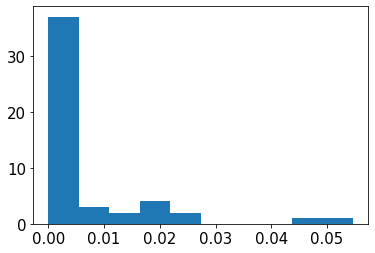

In [31]:
plt.hist(lss.tolist());

In [32]:
np.mean(lss)

DeviceArray(0.00640026, dtype=float32)

#### Mean loss grad

In [33]:
%%time

key, *subkeys = split(key, 51)
subkeys = np.array(subkeys)

p, hp = eqx.partition(params, train_params)

l, g = value_and_grad(avg_simple_loss)(p, hp, fstep, fspace, istate, subkeys)

CPU times: user 9.87 s, sys: 3.83 s, total: 13.7 s
Wall time: 10.7 s


In [34]:
l, g

(DeviceArray(0.00485867, dtype=float32),
 {'alpha': None,
  'cellRad': None,
  'cellRadBirth': None,
  'degRate': None,
  'diffCoeff': None,
  'div_gamma': None,
  'div_k': DeviceArray([ 0.00772671, -0.0066722 ], dtype=float32),
  'eps_OneOne': None,
  'eps_OneTwo': None,
  'eps_TwoTwo': None,
  'mech_relaxation_steps': None,
  'n_chem': None,
  'n_ones_init': None,
  'ncells_add': None,
  'ncells_init': None,
  'r_cutoff': None,
  'r_cutoffDiff': None,
  'r_onset': None,
  'r_onsetDiff': None,
  'sec_gamma': None,
  'sec_k': None,
  'sec_max': None})

## Optimization loop

In [98]:
EPOCHS = 20
BATCH_SIZE = 20

LEARNING_RATE = 1.



p, hp = eqx.partition(params, train_params)

optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#store initial params
params_t = [p]


#store loss at initial params
key, *batch_subkeys = split(key, BATCH_SIZE+1)
batch_subkeys = np.array(batch_subkeys)


l, grads = value_and_grad(avg_simple_loss)(p, hp, fstep, fspace, istate, batch_subkeys)

loss_t = [float(l)]



for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    key, *batch_subkeys = split(key, BATCH_SIZE+1)
    batch_subkeys = np.array(batch_subkeys)
    
    updates, opt_state = optimizer.update(grads, opt_state, p)
    p = eqx.apply_updates(p, updates)
    
    l, grads = value_and_grad(avg_simple_loss)(p, hp, fstep, fspace, istate, batch_subkeys)    
    
    loss_t.append(float(l))
    params_t.append(p)

100%|████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.65s/it]


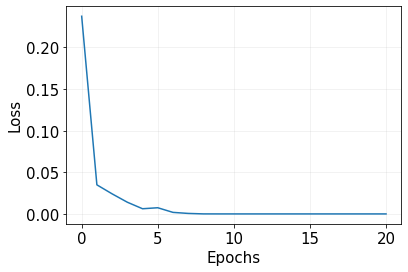

In [99]:
plt.plot(loss_t)
#plt.yscale('log')

plt.grid(alpha=.2)

plt.xlabel('Epochs')
plt.ylabel('Loss');

In [100]:
p

{'alpha': None,
 'cellRad': None,
 'cellRadBirth': None,
 'degRate': None,
 'diffCoeff': None,
 'div_gamma': None,
 'div_k': DeviceArray([8.808182, 3.180714], dtype=float32),
 'eps_OneOne': None,
 'eps_OneTwo': None,
 'eps_TwoTwo': None,
 'mech_relaxation_steps': None,
 'n_chem': None,
 'n_ones_init': None,
 'ncells_add': None,
 'ncells_init': None,
 'r_cutoff': None,
 'r_cutoffDiff': None,
 'r_onset': None,
 'r_onsetDiff': None,
 'sec_gamma': None,
 'sec_k': None,
 'sec_max': None}

In [101]:
# merge params dicts
all_params = eqx.combine(p, hp)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, key)

In [102]:
# Calculate metric of final structure
diff_avg_divrates(fstate)

DeviceArray(-9.403479e-05, dtype=float32)

<AxesSubplot:>

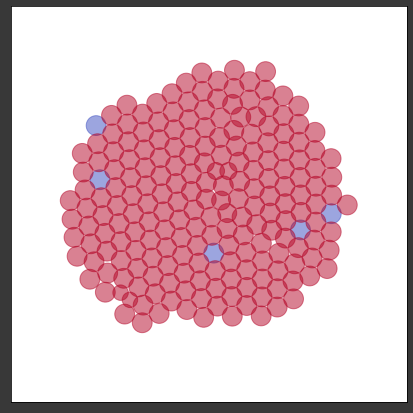

In [103]:
draw_circles_ctype(fstate)

<AxesSubplot:>

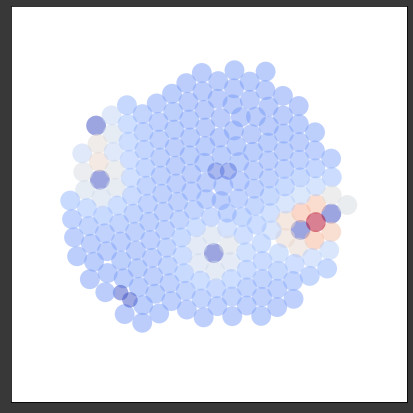

In [104]:
draw_circles_divrate(fstate)

In [105]:
fstate.divrate[fstate.celltype==1]

DeviceArray([7.8322522e-09, 2.8471607e-07, 6.1156804e-08, 9.0994547e-07,
             8.1235380e-10], dtype=float32)